In [2]:
#imports
import torch
from torch import nn
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
import json
import glob
import time
from PIL import Image

In [3]:
from transformers import CLIPProcessor, CLIPModel

device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

preprocess = processor.feature_extractor
tokenizer = processor.tokenizer

c:\python\lib\site-packages\transformers\models\clip\processing_clip.py:142: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


In [4]:
class MLP(nn.Module):
    def __init__(self, dense_size, vocab_size):
        super().__init__()
        self.vocab_size = vocab_size
        self.linear = nn.Linear(dense_size, 1)
        self.linear.apply(self._init_weights)
        
    def _init_weights(self, module):
        torch.nn.init.kaiming_normal_(module.weight.data, nonlinearity="relu")
    
    def forward(self, last_hidden_states, input_ids, attention_mask):
        batch_size = last_hidden_states.shape[0]
        tok_weights = torch.log1p(torch.relu(self.linear(last_hidden_states))).squeeze(-1)*attention_mask
        lex_weights = torch.zeros(batch_size, self.vocab_size).to(device)
        columns = torch.arange(batch_size).repeat((77,1)).T
        lex_weights[columns, input_ids.type(torch.int64)] = tok_weights
        return lex_weights

In [5]:
class MLM(nn.Module):
    def __init__(self, dense_size, vocab_size):
        super().__init__()
        self.linear = nn.Linear(dense_size, vocab_size)
        
    def forward(self, dense_vec):
        term_importances = torch.log1p(torch.relu(self.linear(dense_vec)))
        return term_importances

In [6]:
def test_sparse_performance(MLP, MLM, test_ims, test_lhs, test_ids, test_att):
    with torch.no_grad():
        x, _ = test_ims.shape
        encoded_ims = torch.empty(int(x), 49408).to(device)
        for i in range(0, len(test_ims), 64):
            encoded_ims[i:i+64] = MLM(test_ims[i:i+64])

        encoded_caps = torch.empty(int(x*5), 49408)
        for i in range(0, len(test_lhs), 64):
            encoded_caps[i:i+64] = MLP(test_lhs[i:i+64], test_ids[i:i+64], test_att[i:i+64])
            
            
        #encoded_images = encoded_images / encoded_images.norm(dim=-1, keepdim=True)
        #encoded_captions = encoded_captions / encoded_captions.norm(dim=-1, keepdim=True)

        recall_1, recall_5, recall_10 = [],[],[]
        i = 0
        image_id = 0
        for text_feature in encoded_caps:
            similarity = (100.0 * text_feature.to(device) @ encoded_ims.T).softmax(dim=-1)
            _, indices = similarity.topk(10)

            recall_1.append(image_id in indices[0])
            recall_5.append(image_id in indices[:5])
            recall_10.append(image_id in indices)
    
            i += 1
            if i == 5:
                i = 0
                image_id += 1

        return torch.Tensor(recall_1).mean(), torch.Tensor(recall_5).mean(), torch.Tensor(recall_10).mean()       

In [7]:
class TrainBatches():
    def __init__(self, image_vectors, captions):

        self.images = image_vectors
        self.captions  = captions

    def __len__(self):
        return len(self.captions)

    def __getitem__(self, idx):
        image = self.images[idx]
        caption = self.captions[idx]
        return image,caption

In [8]:
#open the json file for annotations
f = open('datasets/flickr30k/dataset_flickr30k.json')
data = json.load(f)

# load all captions
caps = [x['sentences'] for x in data['images'] if x.get('split') == 'train']
test_caps = [x['sentences'] for x in data['images'] if x.get('split') == 'test']

files = []
test_files = []
for x in data['images']:
    if x.get('split') == 'train':
        files.append('datasets/flickr30k/train/' + x['filename'])
    
    elif x.get('split') == 'test':
        test_files.append('datasets/flickr30k/test/' + x['filename'])
            
captions = []
for x in caps:
    for y in x:
        captions.append(y)
        
test_captions = []
for x in test_caps:
    for y in x:
        test_captions.append(y)
    
captions = [x.get('raw') for x in captions]
test_captions = [x.get('raw') for x in test_captions]

# these captions are too long and need adjusting
captions[13035] = 'Four young adults sit outside on a wooden deck near a building around a small round table, while another person stands on the edge of the deck, leaning on the wooden railing, with the sun shining on one of them, one holding a cellphone out in front of himself and another holding a green and red soda can.'
captions[14580] = 'A man wearing a helmet, red pants with white and a white and red shirt is on a small bicycle using only his hands, while another man wearing a light blue shirt with dark blue trim and black pants with red stripes is standing nearby, gesturing toward the first man and holding a small figurine.'
captions[120165] = 'In this photo there is a man in a dirty white shirt and a black hat with yellow stained teeth, he looks happy and it appears that he is also repairing something.'
test_captions[3905] = 'Two boys are looking upwards with their arms streteched to the sky, the boy on the left is wearing a blue vest jacket with a gray shirt, black jogging pants and a hat, and the boy on the right is wearing a silver vest jacket, with blue long-sleeved undershirt, gray pants, black tennis shoes and has black short hair and glasses.'

In [8]:
files = files[0:10]
captions = captions[0:50]

test_files = test_files[0:10]
test_captions = test_captions[0:50]

In [10]:
# encode images
L = len(files)
batch_size = 128
t1 = time.time()
with torch.no_grad():
    encoded_ims = torch.Tensor()
    for i in range(0, L, batch_size):
        print(i,"/",L, end='\r')
        images = torch.Tensor().to(device)
        for x in range(batch_size):
            if (i + x) < L:
                image = preprocess(Image.open(files[i+x]), return_tensors='pt')['pixel_values'].to(device)
                images = torch.cat((images, image), 0)
                
        ims = model.vision_model(images).pooler_output
        ims = model.visual_projection(ims)
        encoded_ims = torch.cat((encoded_ims, ims.to("cpu")), 0)

p = 0
encoded_images = torch.Tensor().to(device)
for image in encoded_ims:
    if (p%100) == 0:
        print(p,"/",L, end='\r')
        
    encoded_images = torch.cat((encoded_images, image.to(device).repeat(5,1)), 0)
    p += 1
    
print("")
print("done")
print(time.time() - t1)

28900 / 29000 / 29000 / 2900029000 / 29000 / 29000 / 29000 / 29000 / 2900029000 / 29000 / 29000
done
269.7391691207886


In [8]:
encoded_images = torch.load("pt datafiles/flickr/MLP/encoded_images_vitb32.pt")

In [9]:
encoded_images.shape

torch.Size([145000, 512])

In [10]:
encoded_images = encoded_images.to("cpu")

In [11]:
# encode captions
L = len(captions)
t1 = time.time()
with torch.no_grad():
    tokenized_captions = []
    for i in range(0, L):
        if (i%1000) == 0:
            print(i,"/",L, end='\r')
        text = tokenizer(captions[i], padding='max_length', max_length=77, return_tensors='pt').to(device)
        tokenized_captions.append(text)
        
print("")
print("done")
print(time.time() - t1)

144000 / 145000 145000 / 145000 / 145000 / 145000 / 145000 / 145000 / 145000 / 145000 / 145000 / 145000 / 145000145000 / 145000 / 145000 / 145000 / 145000 / 145000 / 145000 / 145000 / 145000 / 145000 / 145000 / 145000 / 145000 / 145000 / 145000 / 145000 / 145000 / 145000 / 145000 / 145000 / 145000 / 145000 / 145000 / 145000 / 145000 / 145000 / 145000 / 145000 / 145000 / 145000 / 145000 / 145000 / 145000 / 145000 / 145000 / 145000 / 145000 / 145000 / 145000 / 145000 / 145000 / 145000 / 145000 / 145000 / 145000 / 145000 / 145000 / 145000 / 145000
done
28.39777946472168


In [12]:
# encode test images
L = len(test_files)
batch_size = 128
with torch.no_grad():
    test_ims = torch.Tensor().to(device)
    for i in range(0, L, batch_size):
        print(i,"/",L, end='\r')
        images = torch.Tensor().to(device)
        for x in range(batch_size):
            if (i + x) < L:
                image = preprocess(Image.open(test_files[i+x]), return_tensors='pt')['pixel_values'].to(device)
                images = torch.cat((images, image), 0)
                
        ims = model.vision_model(images).pooler_output
        ims = model.visual_projection(ims)
        test_ims = torch.cat((test_ims, ims), 0)

test_images = torch.Tensor().to(device)
for image in test_ims:
    test_images = images = torch.cat((test_images, image.repeat(5,1)), 0)
    
print("")
print("done")

896 / 1000
done


In [9]:
test_images = torch.load("pt datafiles/flickr/MLP/test_images_vitb32.pt")

In [13]:
# encode test captions
L = len(test_captions)
batch_size = 256
with torch.no_grad():
    test_features = torch.Tensor().to(device)
    test_ids = torch.Tensor().to(device)
    test_masks = torch.Tensor().to(device)
    for i in range(0, L, batch_size):
        print(i,"/",L, end='\r')
        text = tokenizer(test_captions[i:i+batch_size], padding='max_length', max_length=77, return_tensors='pt').to(device)
        text_lhs = model.text_model(**text).last_hidden_state
        text_lhs = model.text_projection(text_lhs)
        
        test_features = torch.cat((test_features, text_lhs), 0)
        test_ids = torch.cat((test_ids, text.input_ids), 0)
        test_masks = torch.cat((test_masks, text.attention_mask), 0)
        
print("")
print("done")

4864 / 5000
done


In [14]:
batchsize = 64

dataset = TrainBatches(encoded_images, tokenized_captions)
train_dataloader = DataLoader(dataset, batch_size = batchsize, shuffle=True)

In [10]:
dense_text_size = model.text_projection.weight.shape[0]
dense_image_size = model.visual_projection.weight.shape[0]
vocab_size = model.text_model.config.vocab_size

text_encoder = MLP(dense_text_size, vocab_size).to(device)
image_encoder = MLM(dense_image_size, vocab_size).to(device)

In [18]:
#before training
rec1,rec5,rec10 = test_sparse_performance(text_encoder, image_encoder, test_images, test_features, test_ids, test_masks)

print(rec1)
print(rec5)
print(rec10)

tensor(0.0010)
tensor(0.0042)
tensor(0.0100)


In [17]:
rec1,rec5,rec10 = 0.001, 0.0042, 0.01

In [16]:
print(torch.cuda.memory_allocated())

1819632128


In [23]:
print(torch.cuda.memory_allocated())

2571546112


loss: 3068.7309080362322265
R@1: tensor(0.4426)

loss:: 1 batch: 2264 / 2265 1871.2928199470043
R@1: tensor(0.4536)

loss:: 2 batch: 2264 / 2265 1772.6852666139603
R@1: tensor(0.4600)

loss: 1406.7945295572282265
R@1: tensor(0.4814)

loss:: 4 batch: 2264 / 2265 1296.0725738704205
R@1: tensor(0.4964)

loss:: 5 batch: 2264 / 2265 1241.6154988408089
R@1: tensor(0.5038)

loss:: 6 batch: 2264 / 2265 1140.6074836850166
R@1: tensor(0.5034)

loss:: 7 batch: 2264 / 2265 1138.273571640253
R@1: tensor(0.5042)

loss:: 8 batch: 2264 / 2265 1135.1767591536045
R@1: tensor(0.5044)


done


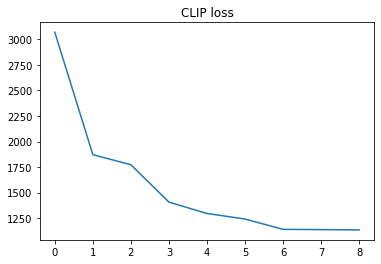

In [18]:
loss_img = torch.nn.CrossEntropyLoss()
loss_txt = torch.nn.CrossEntropyLoss()
params = list(text_encoder.parameters()) + list(image_encoder.parameters())
optimizer = torch.optim.Adam(params, lr=1e-3,betas=(0.9,0.98),eps=1e-6,weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[3,6], gamma=0.1)

vocab_size = model.text_model.config.vocab_size
epochs = 9
totalbatches = int(len(dataset) / batchsize)
logit_scale = model.logit_scale.exp().item()
losses=[]
test_loss=[[rec1],[rec5],[rec10]]
for epoch in range(0, epochs):
    i = 0
    batch_loss = 0
    for batch in train_dataloader:
        if i % 2 == 0:
            print("epoch:", epoch, "batch:", i, "/", totalbatches, end='\r')
       
        optimizer.zero_grad()
        dense_images, tokenized_caps = batch
        dense_images = dense_images.to(device)
        
        with torch.no_grad():
            tokenized_caps['input_ids'] = tokenized_caps['input_ids'].squeeze()
            tokenized_caps['attention_mask'] = tokenized_caps['attention_mask'].squeeze()

            last_hidden_states = model.text_model(**tokenized_caps).last_hidden_state
            last_hidden_states = model.text_projection(last_hidden_states)
            input_ids = tokenized_caps['input_ids']
            attention_masks = tokenized_caps['attention_mask']
        
        # sparse encoding
        sparse_ims = image_encoder(dense_images)
        sparse_caps = text_encoder(last_hidden_states, input_ids, attention_masks)

        # determine logits
        logits_per_image = sparse_ims @ sparse_caps.t()
        logits_per_text = logits_per_image.t()
        
        # compute losses
        ground_truth = torch.arange(len(dense_images),dtype=torch.long,device=device)
        
        loss = (loss_img(logits_per_image,ground_truth) + loss_txt(logits_per_text,ground_truth))/2
            
        batch_loss += loss.item()
        loss.backward()
        
        optimizer.step()
        i+=1
        
    scheduler.step()
    losses.append(batch_loss)
    print("loss:", batch_loss)
    
    recall1,recall5,recall10 = test_sparse_performance(text_encoder, image_encoder, test_images, test_features, test_ids, test_masks)
    test_loss[0].append(recall1)
    test_loss[1].append(recall5)
    test_loss[2].append(recall10)
    print("R@1:", recall1)
    print("")

print("")
print("done")

plt.plot(losses)
plt.title('CLIP loss')
plt.show()

In [41]:
torch.save({
    'epoch':epoch,
    'model_state_dict': text_encoder.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': batch_loss,
    }, f"Models/MLP" + str(epoch) + ".pt")

torch.save({
    'epoch':epoch,
    'model_state_dict': image_encoder.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': batch_loss,
    }, f"Models/MLM" + str(epoch) + ".pt")

In [13]:
#open the json file for annotations
f = open("C:/Users/Lalashops/Desktop/MasterThesis/random images/vocab.json", encoding = 'utf-8')
vocab = json.load(f)

In [21]:
im_checkpoint = torch.load("Models/8.pt", map_location='cpu')
image_encoder.load_state_dict(im_checkpoint['model_state_dict'])

<All keys matched successfully>

In [19]:
#after training
rec1,rec5,rec10 = test_sparse_performance(text_encoder, image_encoder, test_images, test_features, test_ids, test_masks)

print(rec1)
print(rec5)
print(rec10)

tensor(0.5044)
tensor(0.6874)
tensor(0.7024)


In [20]:
sparse_encoding = image_encoder(test_images[[0,5,10,15,20,25]])

In [21]:
sparse_text = text_encoder(test_features[[0,5,10,15,20,25]], test_ids[[0,5,10,15,20,25]], test_masks[[0,5,10,15,20,25]])

In [22]:
test_captions[0]

'The man with pierced ears is wearing glasses and an orange hat.'

In [23]:
test_captions[1]

'A man with glasses is wearing a beer can crocheted hat.'

In [24]:
test_captions[5]

'A black and white dog is running in a grassy garden surrounded by a white fence.'

In [25]:
#(sparse_encoding / sparse_encoding.norm(dim=-1, keepdim=True))
#(sparse_text / sparse_text.norm(dim=-1, keepdim=True))
logits = logit_scale * (sparse_encoding / sparse_encoding.norm(dim=-1, keepdim=True)) @ (sparse_text / sparse_text.norm(dim=-1, keepdim=True)).t()
logits_t = logits.t()

print(logits)
print(logits_t)

tensor([[20.1928,  4.3878,  6.6389,  4.7664,  5.4430, 10.0567],
        [ 4.9717, 20.8775,  4.2066,  5.9800,  5.2962,  6.5759],
        [ 7.3158,  8.7943, 14.7994,  7.1334, 11.8724,  9.2774],
        [ 6.7561,  4.9785,  6.0736, 18.8672,  8.3631,  7.0799],
        [ 6.4926,  6.3796,  5.5017,  4.5215, 19.1692,  5.8276],
        [ 6.2797,  8.1422,  9.3204,  5.7193, 10.2419, 16.6107]],
       device='cuda:0', grad_fn=<MmBackward0>)
tensor([[20.1928,  4.9717,  7.3158,  6.7561,  6.4926,  6.2797],
        [ 4.3878, 20.8775,  8.7943,  4.9785,  6.3796,  8.1422],
        [ 6.6389,  4.2066, 14.7994,  6.0736,  5.5017,  9.3204],
        [ 4.7664,  5.9800,  7.1334, 18.8672,  4.5215,  5.7193],
        [ 5.4430,  5.2962, 11.8724,  8.3631, 19.1692, 10.2419],
        [10.0567,  6.5759,  9.2774,  7.0799,  5.8276, 16.6107]],
       device='cuda:0', grad_fn=<TBackward0>)


In [22]:
sparse_encoding = image_encoder(test_images[0].to(device))

In [23]:
for idx in torch.topk(sparse_encoding, 20).indices:
    print(list(vocab.keys())[list(vocab.values()).index(idx)], sparse_encoding[idx])

hat</w> tensor(0.9866, device='cuda:0', grad_fn=<SelectBackward0>)
guy</w> tensor(0.9399, device='cuda:0', grad_fn=<SelectBackward0>)
man</w> tensor(0.9007, device='cuda:0', grad_fn=<SelectBackward0>)
head</w> tensor(0.8201, device='cuda:0', grad_fn=<SelectBackward0>)
glasses</w> tensor(0.7760, device='cuda:0', grad_fn=<SelectBackward0>)
sunglasses</w> tensor(0.6727, device='cuda:0', grad_fn=<SelectBackward0>)
cap</w> tensor(0.6670, device='cuda:0', grad_fn=<SelectBackward0>)
!</w> tensor(0.6098, device='cuda:0', grad_fn=<SelectBackward0>)
<|startoftext|> tensor(0.6063, device='cuda:0', grad_fn=<SelectBackward0>)
male</w> tensor(0.5875, device='cuda:0', grad_fn=<SelectBackward0>)
peoples</w> tensor(0.5851, device='cuda:0', grad_fn=<SelectBackward0>)
posing</w> tensor(0.5785, device='cuda:0', grad_fn=<SelectBackward0>)
orange</w> tensor(0.5725, device='cuda:0', grad_fn=<SelectBackward0>)
colorful</w> tensor(0.5534, device='cuda:0', grad_fn=<SelectBackward0>)
hats</w> tensor(0.5512, devi

In [40]:
for idx in torch.topk(sparse_encoding, 20).indices:
    print(list(vocab.keys())[list(vocab.values()).index(idx)], sparse_encoding[idx])

<|startoftext|> tensor(1.0739, device='cuda:0', grad_fn=<SelectBackward0>)
hat</w> tensor(0.8618, device='cuda:0', grad_fn=<SelectBackward0>)
marion tensor(0.8085, device='cuda:0', grad_fn=<SelectBackward0>)
been</w> tensor(0.7757, device='cuda:0', grad_fn=<SelectBackward0>)
head</w> tensor(0.7254, device='cuda:0', grad_fn=<SelectBackward0>)
lean tensor(0.6820, device='cuda:0', grad_fn=<SelectBackward0>)
guy</w> tensor(0.6641, device='cuda:0', grad_fn=<SelectBackward0>)
cap</w> tensor(0.6571, device='cuda:0', grad_fn=<SelectBackward0>)
man</w> tensor(0.5715, device='cuda:0', grad_fn=<SelectBackward0>)
you</w> tensor(0.5583, device='cuda:0', grad_fn=<SelectBackward0>)
glasses</w> tensor(0.5568, device='cuda:0', grad_fn=<SelectBackward0>)
male</w> tensor(0.4906, device='cuda:0', grad_fn=<SelectBackward0>)
colored</w> tensor(0.4888, device='cuda:0', grad_fn=<SelectBackward0>)
happy</w> tensor(0.4861, device='cuda:0', grad_fn=<SelectBackward0>)
hats</w> tensor(0.4832, device='cuda:0', grad

In [100]:
sparse_text[0][4313]

tensor(1.2182, device='cuda:0', grad_fn=<SelectBackward0>)

In [102]:
input_ids

tensor([49406,  1237,  1888,  1791,   593, 42662,  2225,  1012,   536,   911,
         3500,  1519,  4850,   620,   530,   518,  4313,   269, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407], device='cuda:0')

In [106]:
for i in range(len(sparse_encoding)):
    if i not in input_ids:
        sparse_encoding[i] = 0

In [32]:
sparse_encoding.sum()

tensor(207.6797, device='cuda:0', grad_fn=<SumBackward0>)

In [105]:
sparse_encoding.sum()

tensor(142.4648, device='cuda:0', grad_fn=<SumBackward0>)

In [108]:
#(sparse_encoding / sparse_encoding.norm(dim=-1, keepdim=True))
#(sparse_text / sparse_text.norm(dim=-1, keepdim=True))
logits = logit_scale * (sparse_encoding / sparse_encoding.norm(dim=-1, keepdim=True)) @ (sparse_text / sparse_text.norm(dim=-1, keepdim=True)).t()
logits_t = logits.t()

print(logits)
print(logits_t)

tensor([76.1364], device='cuda:0', grad_fn=<SqueezeBackward3>)
tensor([76.1364], device='cuda:0', grad_fn=<TBackward0>)


In [93]:
#(sparse_encoding / sparse_encoding.norm(dim=-1, keepdim=True))
#(sparse_text / sparse_text.norm(dim=-1, keepdim=True))
logits = logit_scale * (sparse_encoding / sparse_encoding.norm(dim=-1, keepdim=True)) @ (sparse_text / sparse_text.norm(dim=-1, keepdim=True)).t()
logits_t = logits.t()

print(logits)
print(logits_t)

tensor([25.7773], device='cuda:0', grad_fn=<SqueezeBackward3>)
tensor([25.7773], device='cuda:0', grad_fn=<TBackward0>)


In [119]:
a = torch.Tensor([1,0,3,0,5,0,7])
b = torch.Tensor([1,0,3,0,5,0,7])

In [114]:
(a / a.norm(dim=-1, keepdim=True))

tensor([0.1091, 0.0000, 0.3273, 0.0000, 0.5455, 0.0000, 0.7638])

In [120]:
logits = a @ b.t()
logits_t = logits.t()

print(logits)
print(logits_t)

tensor(84.)
tensor(84.)


In [111]:
logits = logit_scale * (a / a.norm(dim=-1, keepdim=True)) @ (b / b.norm(dim=-1, keepdim=True)).t()
logits_t = logits.t()

print(logits)
print(logits_t)

tensor(77.4597)
tensor(77.4597)


In [109]:
for idx in torch.topk(sparse_encoding, 10).indices:
    print(list(vocab.keys())[list(vocab.values()).index(idx)], sparse_encoding[idx])

<|startoftext|> tensor(1.2251, device='cuda:0', grad_fn=<SelectBackward0>)
two</w> tensor(1.1195, device='cuda:0', grad_fn=<SelectBackward0>)
yard</w> tensor(0.7994, device='cuda:0', grad_fn=<SelectBackward0>)
guys</w> tensor(0.7923, device='cuda:0', grad_fn=<SelectBackward0>)
young</w> tensor(0.5262, device='cuda:0', grad_fn=<SelectBackward0>)
out</w> tensor(0.3668, device='cuda:0', grad_fn=<SelectBackward0>)
<|endoftext|> tensor(0.2504, device='cuda:0', grad_fn=<SelectBackward0>)
shaggy</w> tensor(0.2413, device='cuda:0', grad_fn=<SelectBackward0>)
hands</w> tensor(0.1973, device='cuda:0', grad_fn=<SelectBackward0>)
hair</w> tensor(0.1880, device='cuda:0', grad_fn=<SelectBackward0>)


In [18]:
losses

[2665.9669038951397,
 1367.5952885597944,
 1269.7722907960415,
 811.8109786659479,
 606.2737910971045,
 504.91525573655963,
 391.6623055767268,
 367.54721986316144,
 357.15938295423985]

In [27]:
losses

[2493.7909121215343,
 1384.9443222284317,
 1267.2449124902487,
 803.6581957191229,
 601.3388871252537,
 502.14060947299004]

In [18]:
losses

[218.83666098117828,
 82.03098356723785,
 57.04176379740238,
 42.055708691477776,
 37.70679826219566,
 34.137943376612384,
 32.123214966850355,
 32.69721009978093,
 32.110954195261]

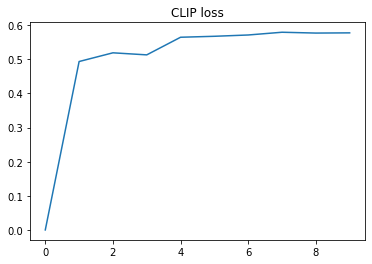

In [19]:
plt.plot(test_loss[0])
plt.title('CLIP loss')
plt.show()
# batch size:16

In [28]:
test_loss[0]

[tensor(0.0006),
 tensor(0.4908),
 tensor(0.5004),
 tensor(0.4918),
 tensor(0.5548),
 tensor(0.5668),
 tensor(0.5740)]

In [19]:
test_loss[0]

[tensor(0.0014),
 tensor(0.4762),
 tensor(0.5018),
 tensor(0.5120),
 tensor(0.5692),
 tensor(0.5820),
 tensor(0.5762),
 tensor(0.5792),
 tensor(0.5784),
 tensor(0.5776)]

In [29]:
test_features[0]

tensor([[ 0.1933,  0.9817,  0.3240,  ...,  0.0012,  0.2655,  0.2338],
        [ 0.1997,  0.0681, -0.1473,  ...,  0.0896,  0.4684, -0.1079],
        [ 0.2068,  0.2499,  0.2512,  ...,  0.3175,  1.0617, -0.2022],
        ...,
        [ 0.1563,  1.1051, -0.3531,  ..., -0.1328,  0.6210,  0.3849],
        [ 0.2267,  1.1112, -0.1367,  ..., -0.0296,  0.4944,  0.2546],
        [ 0.4281,  0.2324, -0.3460,  ..., -0.3270,  0.4068,  0.4171]],
       device='cuda:0')

In [30]:
test_captions[0]

'The man with pierced ears is wearing glasses and an orange hat.'

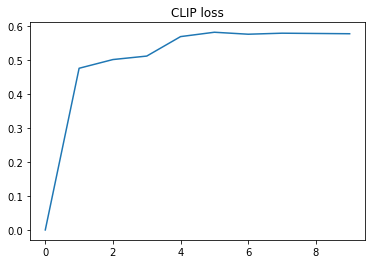

In [20]:
plt.plot(test_loss[0])
plt.title('CLIP loss')
plt.show()
# batch size:16

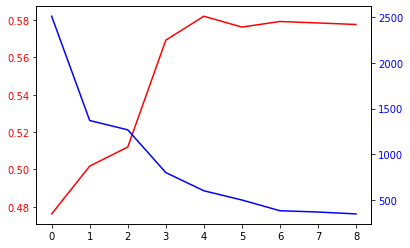

In [21]:
fig, ax = plt.subplots()

ax.plot(test_loss[0][1:], color='red')
ax.tick_params(axis='y', labelcolor='red')

ax2 = ax.twinx()
ax2.plot(losses, color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

plt.show()
# batch size:16

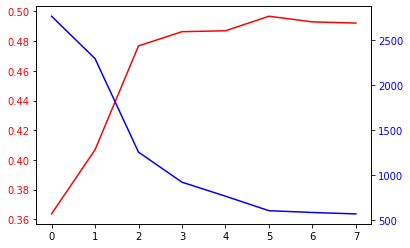

In [29]:
fig, ax = plt.subplots()

ax.plot(test_loss[0][2:], color='red')
ax.tick_params(axis='y', labelcolor='red')

ax2 = ax.twinx()
ax2.plot(losses[1:], color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

plt.show()
# batch size:64

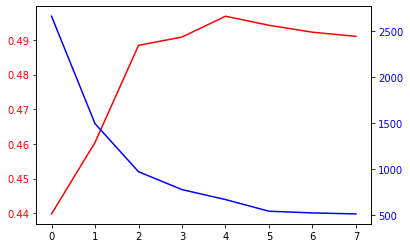

In [17]:
fig, ax = plt.subplots()

ax.plot(test_loss[0][2:], color='red')
ax.tick_params(axis='y', labelcolor='red')

ax2 = ax.twinx()
ax2.plot(losses[1:], color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

plt.show()
# batch size:64

In [22]:
test_files[0]

'datasets/flickr30k/test/1007129816.jpg'

In [23]:
blocksize = 150
with torch.no_grad():
    regions = []
    image = Image.open(test_files[0])
    coords = torch.Tensor([0,0,0,0])
    for x in range(0, 440, blocksize):
        for y in range(0, 480, blocksize):
            left = y
            upper = x
            right = y + blocksize
            lower = x + blocksize
            coords = torch.vstack((coords, torch.Tensor([left,upper,right,lower])))
            regions.append(image.crop((left,upper,right,lower)))

    print(image)
    processed_image = preprocess(image, return_tensors='pt')['pixel_values'].to(device)
    print(processed_image.shape)

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x461 at 0x1228B0ABB80>
torch.Size([1, 3, 336, 336])


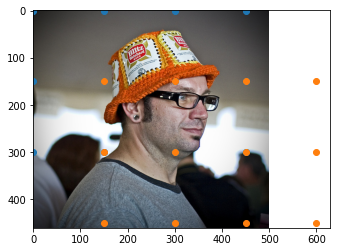

In [24]:
plt.imshow(image)
plt.scatter(coords[1:, 0], coords[1:, 1])
plt.scatter(coords[1:, 2], coords[1:, 3])

In [25]:
with torch.no_grad():
    test_ims = torch.Tensor().to(device)
    for region in regions:
        im = preprocess(region, return_tensors='pt')['pixel_values'].to(device)
        im = model.vision_model(im).pooler_output
        im = model.visual_projection(im)
        test_ims = torch.cat((test_ims, im), 0)

In [26]:
test_ims.shape

torch.Size([12, 768])

In [27]:
hat = []
head = []
glasses = []
orange = []
for test_im in test_ims:
    sparse_encoding = image_encoder(test_im)
    
    hat.append(sparse_encoding[3801].item())
    head.append(sparse_encoding[1375].item())
    glasses.append(sparse_encoding[6116].item())
    orange.append(sparse_encoding[4287].item())

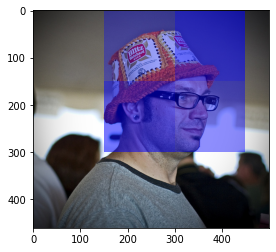

In [28]:
plt.imshow(image)

for i, coor in enumerate(coords[1:]):
    plt.axhspan(coor[1], coor[3], coor[0]/500, coor[2]/500, facecolor='blue', alpha=hat[i]/2)

plt.show()

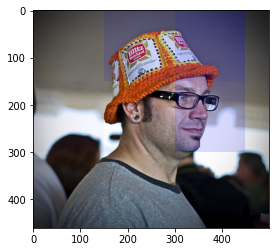

In [29]:
plt.imshow(image)

for i, coor in enumerate(coords[1:]):
    plt.axhspan(coor[1], coor[3], coor[0]/500, coor[2]/500, facecolor='blue', alpha=head[i]/2)

plt.show()

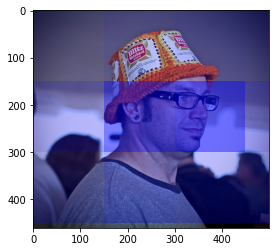

In [30]:
plt.imshow(image)

for i, coor in enumerate(coords[1:]):
    plt.axhspan(coor[1], coor[3], coor[0]/500, coor[2]/500, facecolor='blue', alpha=glasses[i]/2)

plt.show()

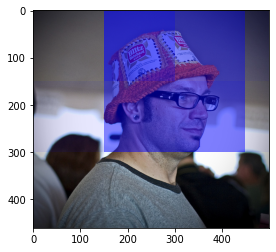

In [31]:
plt.imshow(image)

for i, coor in enumerate(coords[1:]):
    plt.axhspan(coor[1], coor[3], coor[0]/500, coor[2]/500, facecolor='blue', alpha=orange[i]/2)

plt.show()

In [36]:
sparse_encoding = image_encoder(test_images[0])

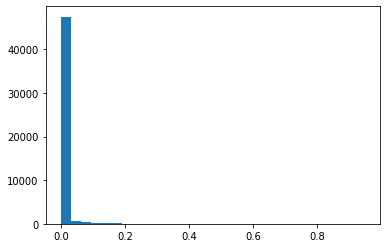

tensor(222.6798, device='cuda:0', grad_fn=<NormBackward1>)


In [37]:
plt.hist(sparse_encoding.cpu().detach().numpy(), bins=30)
plt.show()

l1_regularization = torch.norm(sparse_encoding, 1)
print(l1_regularization)

In [38]:
sparse_encoding.unique(return_counts=True)

(tensor([0.0000e+00, 2.8026e-45, 7.0065e-45,  ..., 9.0799e-01, 9.1487e-01,
         9.4901e-01], device='cuda:0', grad_fn=<Unique2Backward0>),
 tensor([25764,     1,     1,  ...,     1,     1,     1], device='cuda:0'))

In [39]:
(sparse_encoding > 0.001).unique(return_counts=True)

(tensor([False,  True], device='cuda:0'),
 tensor([44715,  4693], device='cuda:0'))